# Behavioural validation of the extreme PCA

Run the MVET_IDP_PCA.ipynb first to find the extreme principal components (PCs).
In this script we are going to look at the correlation between the first two extreme PCs and several behavioural measures from the UKB.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
# For using R within python
%load_ext rpy2.ipython

In [3]:
%%R
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          1.0                         
year           2021                        
month          05                          
day            18                          
svn rev        80317                       
language       R                           
version.string R version 4.1.0 (2021-05-18)
nickname       Camp Pontanezen             


In [4]:
def retrieve_UKBB_covariates(csv_file_path, fields_code_list, fileds_name_list, 
                             save_path = None, drop_nans = True):
    '''
    Example:
        csv_file_path = '/project_freenas/3022017.02/UKB/phenotypes/ukb35187.csv'
        save_path =  '/project_freenas/3022017.02/UKB/phenotypes/test.csv'
        fields_code_list = ['21003-2.0', '31-0.0', '54-2.0']
        fileds_name_list = ['age', 'gender', 'site_id']
        
        covariates, subs = retrieve_UKBB_covariates(csv_file_path, fields_code_list, 
                                          fileds_name_list, save_path)
    '''
    
    ukbb_covariates = pd.read_csv(csv_file_path, encoding= 'unicode_escape', 
                                   usecols=['eid'] + fields_code_list)
    if drop_nans:
        ukbb_covariates = ukbb_covariates.dropna()
    ukbb_subs = list(ukbb_covariates['eid'])
    ukbb_subs = [str(u) for u in ukbb_subs]
    ukbb_covariates['eid'] = ukbb_subs
    ukbb_covariates = ukbb_covariates.set_index('eid')
    c = dict()
    for i, code in enumerate(fields_code_list):
        c[code] = fileds_name_list[i]
    ukbb_covariates = ukbb_covariates.rename(columns=c)
    if save_path is not None:
        ukbb_covariates.to_csv(save_path)
    return ukbb_covariates, ukbb_subs

# Fluid intelligence
First we will look with a bit more detail at fluid intelligence, as this is usually used to validate a new method.

In [5]:
# Remove num memory, for very few participants and pros mem, as categorical
# https://biobank.ctsu.ox.ac.uk/crystal/label.cgi?id=100026
cp_code_list = [#'4282-2.0', # Numeric memory
                '20016-2.0', # Reasoning/fluid int
                #'20023-2.0', # Reaction time
                #'399-2.2', # Visual memory, pair matching
                #'21004-2.0', # tower_rearranging, number puzzles correct
                #'6348-2.0', # duration trail n
                #'6350-2.0', # duration trail a
                #'6373-2.0', # matrix pattern puzzles solved
                #'23324-2.0' # digits matched correctly
               ] #  399 had 3 pair and 6 pair
cp_name_list = [#'Numeric_memory',
                'Fluid_intelligence', 
                #'Reaction_time', 
                #'Visual_memory', 
                #'tower_rearranging', 
                #'trail_making_n', 
                #'trail_making_a',
                #'matrix_pattern_completion', 
                #'symbol_digit_substitution'
               ] #'numeric_memory'
CPs, subs = retrieve_UKBB_covariates('/project_freenas/3022017.02/UKB/phenotypes/current/32_cognitive_phenotypes.csv', cp_code_list, cp_name_list)

## Preprocess the behavioural data
1. To make the data more Gaussian transfer some to log space
2. Normalize before PCA, as PCA tries to maximize the variance, and otherwise the largest component will explain the most variance. 

In [6]:
#CPs['Reaction_time'] = np.log(CPs['Reaction_time'])
#CPs['Visual_memory'] = np.log(CPs['Visual_memory']+1)
scaler = MinMaxScaler()
CPs_scaled = scaler.fit_transform(CPs)
CPs_scaled_df = pd.DataFrame(data = CPs_scaled, columns = CPs.columns)
CPs_scaled_df.describe()
CPs_scaled_df.index = list(map(int,subs))

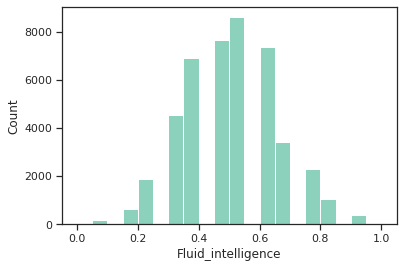

In [7]:
for cp in cp_name_list:
    plt.figure()
    sns.histplot(data=CPs_scaled_df[cp], bins = 20)

## Select standard PC or extreme PC
Select the participants that have both the PCs (brain data) and the CPs data available. 
Select if you want the standard space PCs (PCs_ss.csv) or the extreme PCs (PCs.csv)

In [8]:
Z_df = pd.read_csv('/project_cephfs/3022017.02/projects/big_data/data/ukb_processed_4/deviation_scores.csv', index_col=0)
standard = False #else extreme
if standard:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs_ss.csv')
    ending = 'standard'
else:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs.csv')
    ending = 'extreme'

PCs_df.index = Z_df.index
PCs_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V385,V386,V387,V388,V389,V390,V391,V392,V393,V394
1000050,86.936095,38.567922,73.477932,-11.571167,-31.880542,4.127841,1.894238,-5.017314,-19.587740,21.407747,...,10.659113,8.746197,20.513950,1.100517,0.078258,8.957418,5.931065,-7.955656,-12.953428,-17.197706
1000853,106.209221,-1.263881,-26.921476,24.042827,4.524873,2.884952,-35.145050,7.100404,-29.619982,-7.868569,...,2.800420,1.554645,6.043969,1.195651,2.038939,-1.235958,-6.841360,-4.308471,-0.760121,-4.716729
1000871,81.831362,-10.044895,17.354035,10.263175,22.717061,12.848750,5.785556,-10.243469,3.175606,0.905899,...,-0.470076,-1.901821,0.660914,-0.667041,0.638762,-1.677394,-0.268058,2.172508,1.555563,-0.130200
1000910,61.892211,22.392355,8.957376,11.887004,18.109057,8.593101,-4.821732,-7.982525,0.408153,9.457089,...,-1.500316,-0.765088,1.242212,-1.817681,1.041462,1.820262,0.717599,-0.845861,1.507726,0.671432
1001018,80.874316,21.705076,-3.112837,-11.188150,6.198052,2.383058,3.513303,15.881936,-1.971649,-0.761278,...,-6.033837,0.787522,3.211678,1.523732,1.555672,0.296585,0.872588,0.738224,1.809111,1.252140


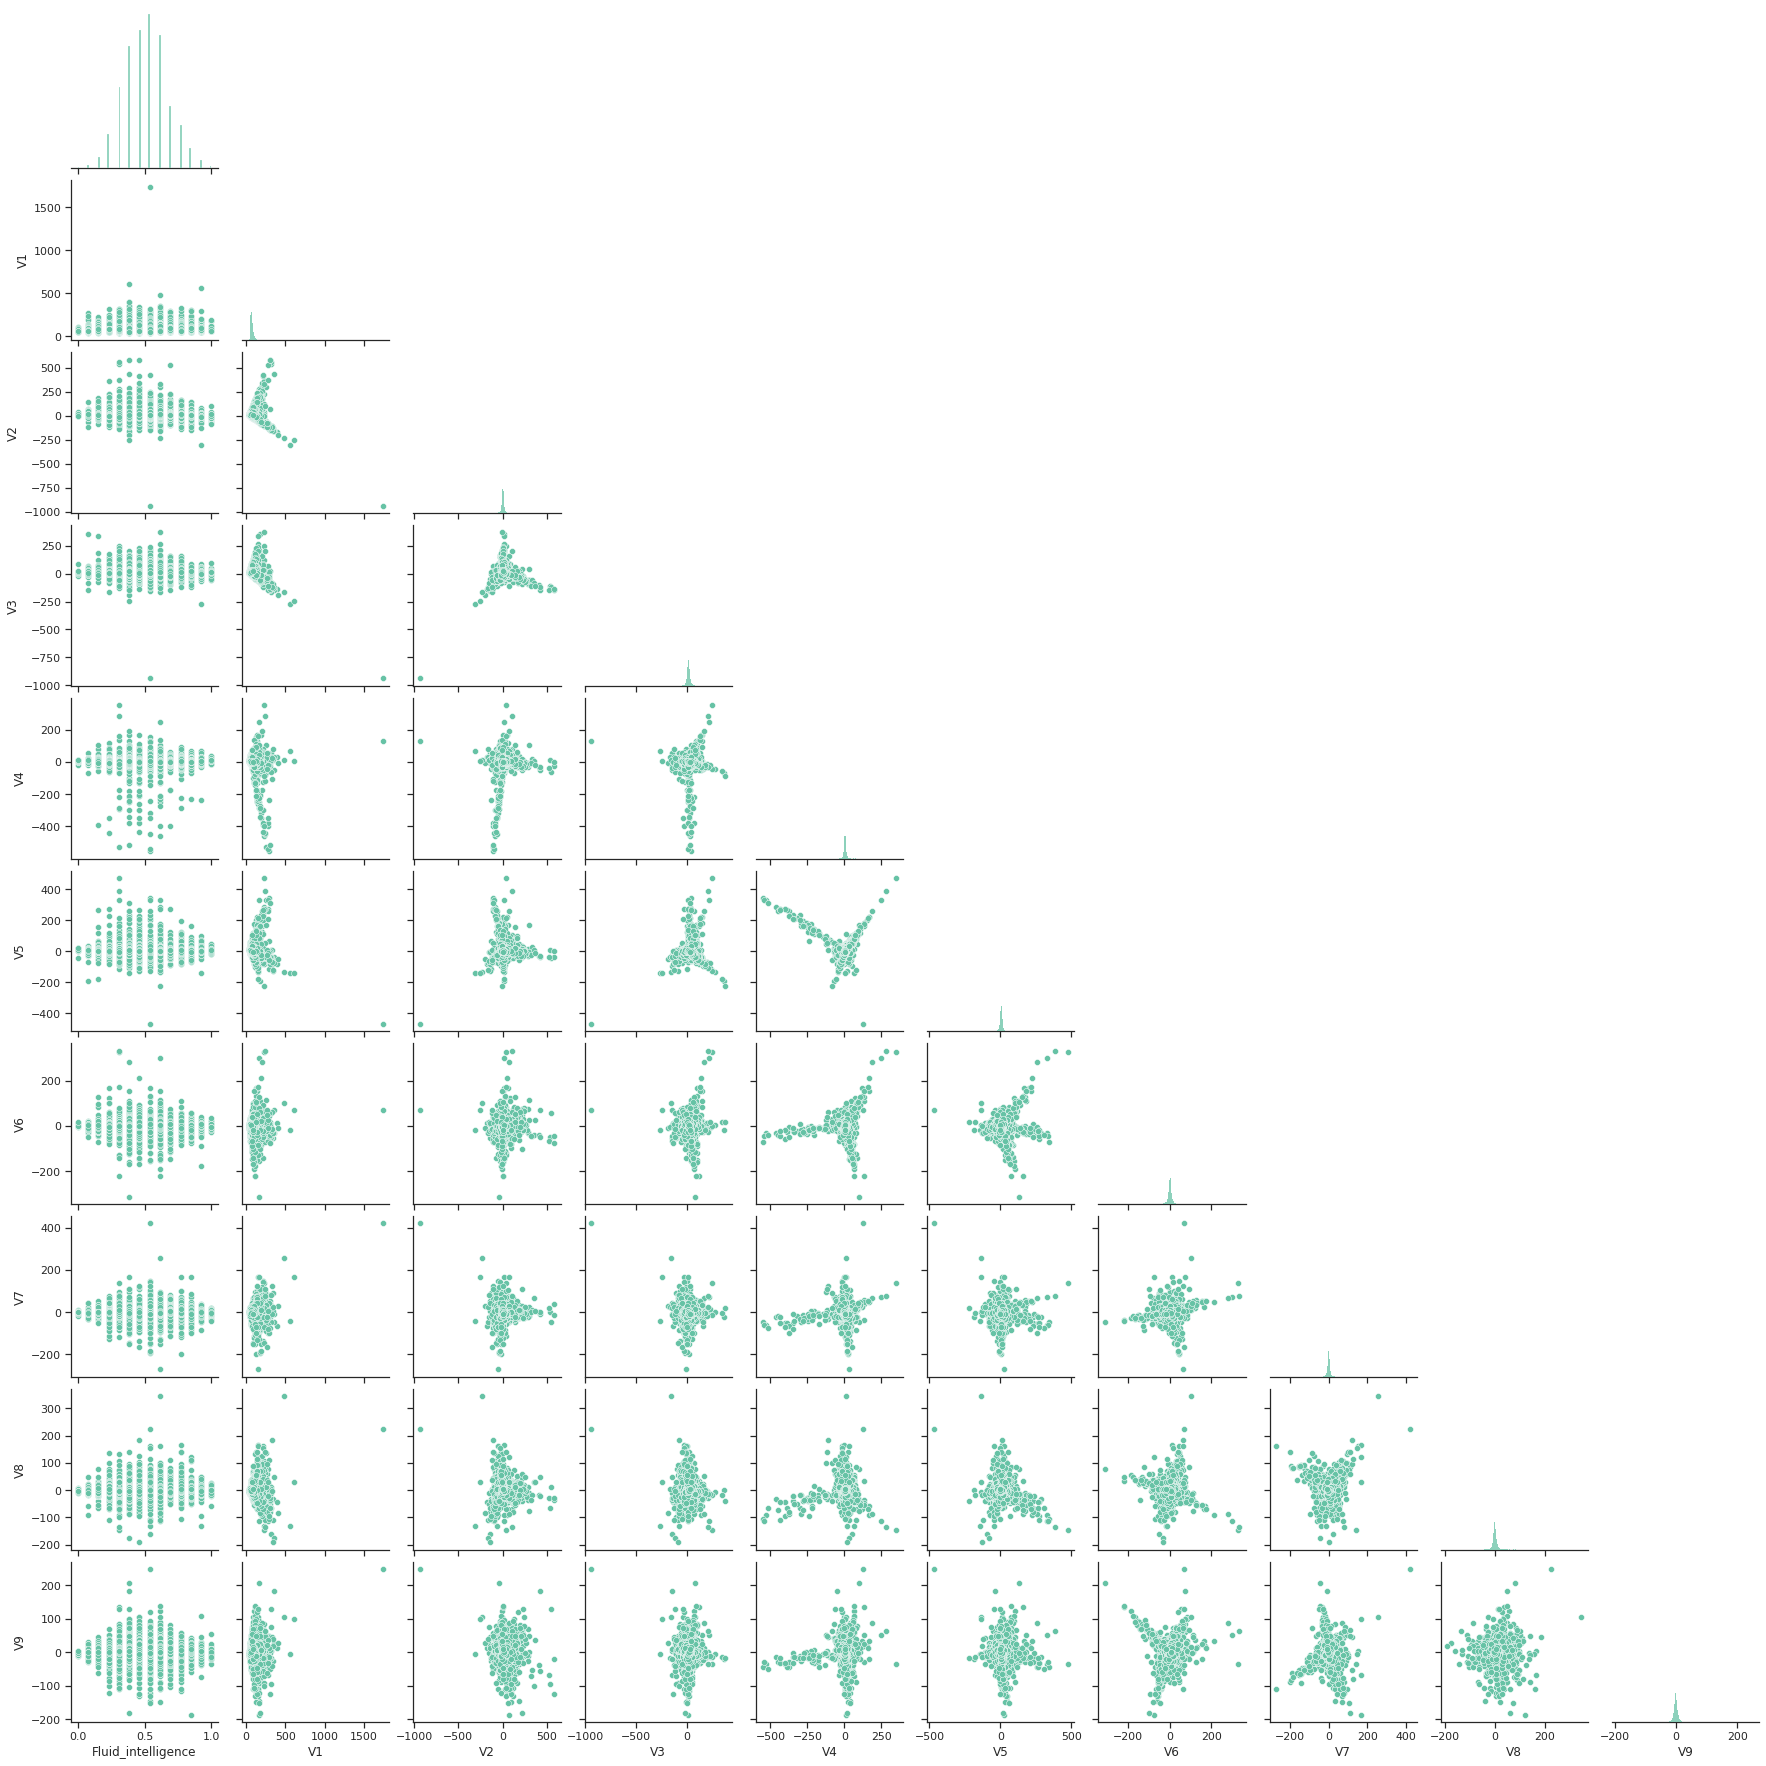

In [9]:
CPs_scaled_df_dep = CPs_scaled_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)]
PCs_df_dep = pd.DataFrame(PCs_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)])
CPs_PCs_df = pd.concat([CPs_scaled_df_dep, PCs_df_dep], axis=1)

sns.pairplot(data = CPs_PCs_df.iloc[:,0:10], corner=True)

## Correlation PC and fluid intelligence 

In [10]:
rho = np.zeros(np.shape(PCs_df_dep)[1])
p = np.zeros(np.shape(PCs_df_dep)[1])
for i in range(np.shape(PCs_df_dep)[1]):
    print(i)
    rho[i], p[i] = stats.spearmanr(CPs_scaled_df_dep, PCs_df_dep.iloc[:,i])
    print('stat:', rho[i], 'pval:', p[i])

0
stat: 0.13080302645029446 pval: 1.6755337187472827e-137
1
stat: -0.13387374705094168 pval: 5.362584014772171e-144
2
stat: -0.06471791676747993 pval: 8.079642481744222e-35
3
stat: -0.046676628791224 pval: 7.09878694425979e-19
4
stat: -0.017855042684183045 pval: 0.0006920611475624215
5
stat: -0.0004723433402719881 pval: 0.9284901588105253
6
stat: 0.02528015250171622 pval: 1.55555281030339e-06
7
stat: 0.01858762972238529 pval: 0.0004125380881463297
8
stat: 0.016331245717626182 pval: 0.0019149060380772996
9
stat: -0.030736405255105875 pval: 5.180855157195025e-09
10
stat: -0.035908951815239044 pval: 8.80144672473516e-12
11
stat: -0.018067287609185686 pval: 0.0005968517042989782
12
stat: 0.0076970506698639165 pval: 0.1436176185618
13
stat: 0.02775091515819096 pval: 1.3373471711811208e-07
14
stat: -0.005370353953078161 pval: 0.3075541815336814
15
stat: -0.008174751081520621 pval: 0.12037108662410011
16
stat: 0.024939092109315754 pval: 2.1463596559709003e-06
17
stat: -0.017507841893613253 pv

stat: 0.008029241386099237 pval: 0.12711701632053382
148
stat: -0.010423369418031951 pval: 0.04764958824053149
149
stat: 0.0023111567671726496 pval: 0.6605765217492217
150
stat: -0.0002817628578857401 pval: 0.9573059846070501
151
stat: -0.003454629184463793 pval: 0.5115816123976131
152
stat: 0.003329176183019193 pval: 0.5270335261553077
153
stat: 0.016188650017056275 pval: 0.002097811321122005
154
stat: -0.02047626170901012 pval: 9.988516335677334e-05
155
stat: -0.027641335791282272 pval: 1.4978709209776976e-07
156
stat: 0.015242151143155677 pval: 0.0037776349308457887
157
stat: 0.018107880433052784 pval: 0.000580092386944324
158
stat: -0.026681086852229047 pval: 3.972435006472487e-07
159
stat: 0.010589830695453733 pval: 0.044208309896632665
160
stat: -0.014204246416904156 pval: 0.006956400376167543
161
stat: -0.0006017129711277843 pval: 0.9089804164620634
162
stat: -0.02433593051868359 pval: 3.7554004981849013e-06
163
stat: -0.01637772081826519 pval: 0.0018585339186720723
164
stat: 0.

stat: -0.0030428003266836034 pval: 0.563176761532411
300
stat: 0.0003135523463804429 pval: 0.9524945006932551
301
stat: -0.020375033357894774 pval: 0.00010810935273419345
302
stat: 0.005986960404399594 pval: 0.2553189662717479
303
stat: 0.011842168609801654 pval: 0.024444162965438308
304
stat: -0.005562806916260896 pval: 0.2905416317511329
305
stat: 0.00889454743997449 pval: 0.09103068355743908
306
stat: -0.0036271565465691748 pval: 0.4907243235214238
307
stat: 0.0064111450352457924 pval: 0.2231777522222646
308
stat: -0.006728107525049134 pval: 0.20112743960211685
309
stat: 0.01079847456631309 pval: 0.04019340340027708
310
stat: 0.004928075583589654 pval: 0.34910147341757836
311
stat: 0.006791805258901402 pval: 0.19689482767517816
312
stat: -0.015787397674830214 pval: 0.0027018201907778577
313
stat: -0.033793183612566495 pval: 1.3405898446057084e-10
314
stat: -0.006293910834276273 pval: 0.23175641917097817
315
stat: -0.01370201535134213 pval: 0.00922807422501652
316
stat: -0.0016200900

In [11]:
p_df = pd.DataFrame(p, columns=['pvalue'])
p_df = p_df.reset_index()

No handles with labels found to put in legend.


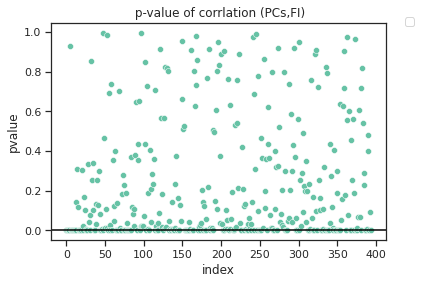

In [12]:
fig=sns.scatterplot(data=p_df, x='index',y='pvalue')
fig.axhline(.05/len(p_df),color='k')
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.title(' p-value of corrlation (PCs,FI)')
plt.show()
plt.close()

In [13]:
print(f'PCs, Number of correlations passing p-value: {sum(p_df.iloc[:,1]<.05/len(p_df))}')

PCs, Number of correlations passing p-value: 74


# Correlation non-IDPs

Correlate the first two extreme PCs to different non IDP values, using a standard spearmanr correlation. The spearmanr correlation does not assume that both distributions are normally distributed. 

Code based on this amazing paper: 
- Non-linearity matters: a deep learning solution to generalization of hidden brain patterns across population cohorts Mariam Zabihi.

In [14]:
PCs=PCs_df.iloc[:,0:3]
nIDP_df=pd.read_csv('/project_cephfs/3022017.02/projects/big_data/data/nIDPs.csv',index_col=0)
data_dictionary=pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/EVT/data_dictionary.csv',index_col=0)

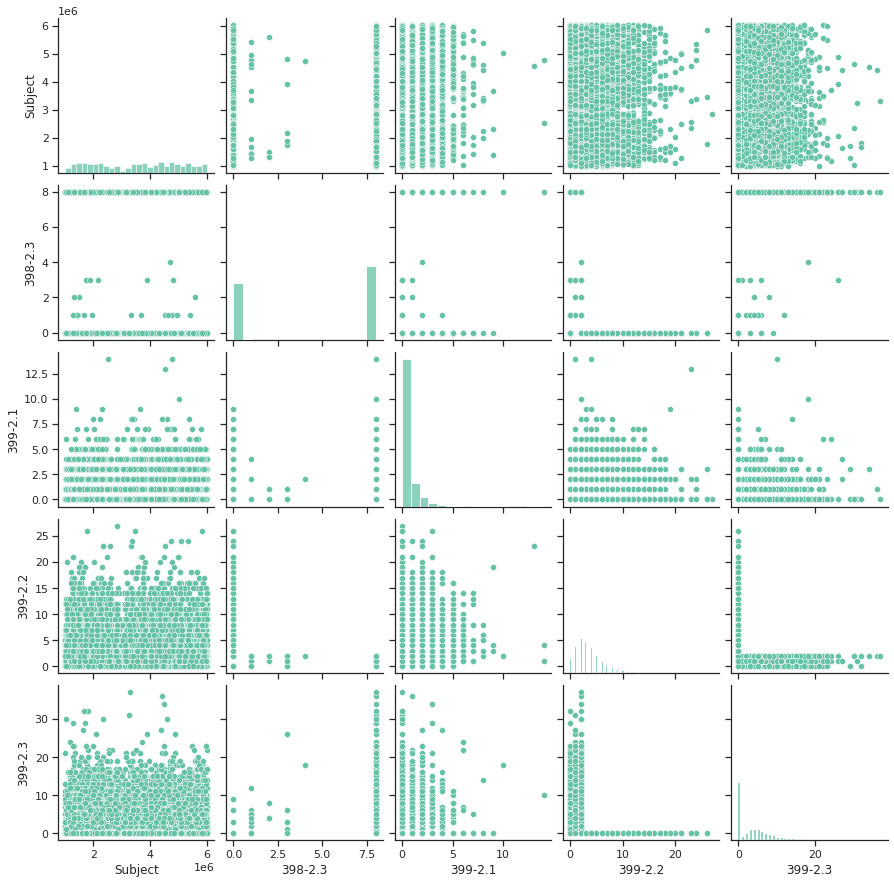

In [15]:
nIDP_df
sns.pairplot(nIDP_df.iloc[:,0:5])

In [16]:
nIDP_df = nIDP_df.set_index('Subject')
nIDP_df.head()

,398-2.3,399-2.1,399-2.2,399-2.3,400-2.1,400-2.2,401-2.0,401-2.1,401-2.2,401-2.3,...,4537-2.0,4548-2.0,4559-2.0,4570-2.0,4581-2.0,4598-2.0,4631-2.0,4653-2.0,54-2.0,21003-2.0
Subject,,,,,,,,,,,,,,,,,,,,,
2909865,NaN,1.0,4.0,NaN,83.0,267.0,3.0,2.0,7.0,2.0,...,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,11025.0,62.0
5580304,0.0,1.0,4.0,0.0,179.0,395.0,9.0,2.0,9.0,0.0,...,7.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,11025.0,66.0
2559492,8.0,0.0,1.0,4.0,70.0,173.0,5.0,4.0,0.0,4.0,...,3.0,4.0,3.0,3.0,3.0,1.0,1.0,0.0,11025.0,51.0
2499418,NaN,0.0,3.0,NaN,65.0,295.0,9.0,2.0,6.0,4.0,...,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,11025.0,56.0
4195994,NaN,0.0,3.0,NaN,90.0,238.0,7.0,8.0,7.0,8.0,...,3.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,11027.0,61.0


In [17]:
X = PCs.join(nIDP_df)
P = pd.DataFrame()
for nIDP in nIDP_df: 
    df=X[['V1','V2', 'V3' ,nIDP]]
    df = df.dropna()
    r,p=spearmanr(df[['V1','V2', 'V3']],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue[['PC1','PC2', 'PC3']]=[-np.log10(p[3,:3])]
    P=pd.concat([P,pvalue])
    
Pvalue=pd.merge(data_dictionary[['FieldID-instance','nIDP_category','Field']],P,how='inner',on='FieldID-instance')
Pvalue=Pvalue.reset_index()
Pvalue=Pvalue.rename(columns={'index':'nIDPs'})
Pvalue=Pvalue.drop(Pvalue[Pvalue['nIDP_category']=='age_sex_site'].index)
Pvalue.head()

,nIDPs,FieldID-instance,nIDP_category,Field,PC1,PC2,PC3
0,0,398-2.3,cognitive_phenotypes,Number of correct matches in round,1.941163,3.225646,1.788563
1,1,399-2.1,cognitive_phenotypes,Number of incorrect matches in round,6.132294,12.660769,1.334830
2,2,399-2.2,cognitive_phenotypes,Number of incorrect matches in round,0.647827,6.422979,1.322165
3,3,399-2.3,cognitive_phenotypes,Number of incorrect matches in round,1.435800,0.985854,0.752389
4,4,400-2.1,cognitive_phenotypes,Time to complete round,3.468573,19.492262,2.715614


Manhattan plot of the p-values for the univariate correlation of non-imaging measures with the first two extreme PCAs and the standard PCAs. The black line shows the Bonferonni-corrected p-value threshold.
We use the log10 scale, so we have to look at values that pass the black line.

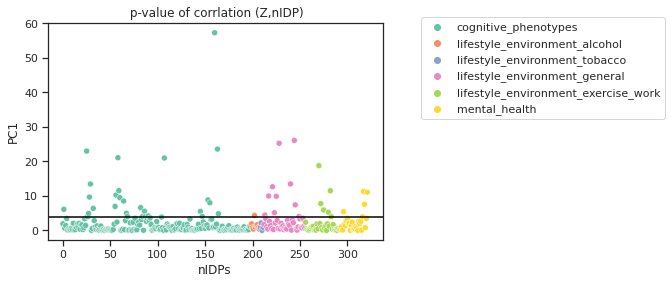

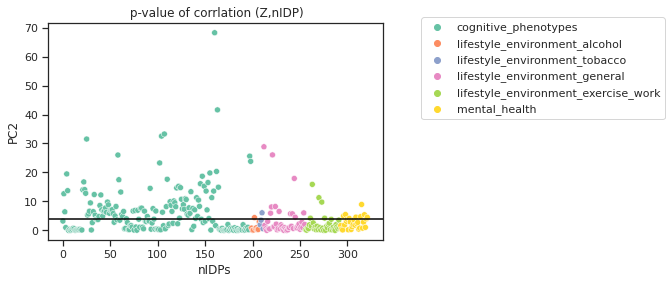

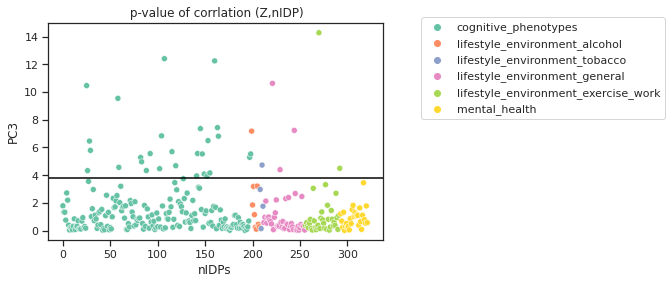

In [18]:
for idp in ['PC1','PC2', 'PC3']:
    fig=sns.scatterplot(data=Pvalue, x='nIDPs',y=idp, hue='nIDP_category')
    fig.axhline(-np.log10(.05/len(P)),color='k')

    plt.legend(bbox_to_anchor=(1.1,1.05))
    plt.title(' p-value of corrlation (Z,nIDP)')
    #plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
print(f'PCA1, Number of correlations passing p-value: {np.sum(P.iloc[:,1]>-np.log10(.05/len(P)))}')
print(f'PCA2, Number of correlations passing p-value: {np.sum(P.iloc[:,2]>-np.log10(.05/len(P)))}')
print(f'PCA3, Number of correlations passing p-value: {np.sum(P.iloc[:,3]>-np.log10(.05/len(P)))}')

PCA1, Number of correlations passing p-value: 52
PCA2, Number of correlations passing p-value: 135
PCA3, Number of correlations passing p-value: 37


## Correlation diagnosis and extreme PCAs
The IDP codes can be found here:
https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=6
We will look at two diagnosis that we expect to have extreme values:
chronic/degenerative neurological problem:
- motor neurone disease (69) - 1259
- myasthenia gravis (59) - 1260
- multiple sclerosis (1995) - 1261
- parkinsons disease (1011) - 1262
- dementia/alzheimers/cognitive impairment (154) - 1263
- other demyelinating disease (not multiple sclerosis) (81) - 1397

In [20]:
df = pd.read_csv("/project_freenas/3022017.02/UKB/phenotypes/current/50_health_outcomes_headers.csv")
diagnosis_ids = [col for col in df if col.startswith('20002')]
diagnosis_ids.append('eid')
diagnosis_df = pd.read_csv("/project_freenas/3022017.02/UKB/phenotypes/current/50_health_outcomes.csv", usecols = diagnosis_ids)
diagnosis_df = diagnosis_df.set_index('eid')

In [21]:
degenerative_df = diagnosis_df[['20002-0.1259', '20002-0.1260', '20002-0.1261', '20002-0.1262', '20002-0.1263', '20002-0.1397']]
print(f'Number of subject with a neurological problem: \n{degenerative_df.sum()}')

Number of subject with a neurological problem: 
20002-0.1259      65
20002-0.1260      58
20002-0.1261    1831
20002-0.1262     948
20002-0.1263     152
20002-0.1397      80
dtype: int64


We want to correlate a continious variable with a binary variable, so we have to use the Point-Biserial Correlation

In [22]:
# Select only participants that also have brain data
degenerative_df = degenerative_df.loc[degenerative_df.index.intersection(PCs_df.index)]
PCs_df_dep = PCs_df.loc[degenerative_df.index]
print(f'Number of subject with a neurological problems and brain data: {degenerative_df.sum().sum()}')

Number of subject with a neurological problems and brain data: 234


In [23]:
PCs=PCs_df.iloc[:,0:3]
X = PCs.join(degenerative_df)
P = pd.DataFrame()
for nIDP in degenerative_df: 
    df=X[['V1','V2', 'V3',nIDP]]
    df = df.dropna()
    r1, p1 = stats.pointbiserialr(df['V1'],df[nIDP])
    r2, p2 = stats.pointbiserialr(df['V2'],df[nIDP])
    r3, p3 = stats.pointbiserialr(df['V3'],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue['PC1'] = -np.log10(p1)
    pvalue['PC2'] = -np.log10(p2)
    pvalue['PC3'] = -np.log10(p3)
    P=pd.concat([P,pvalue])    

In [24]:
P['nIDP_category'] = 'neurodegenerative_disorders'
P['Field'] = ['motor neurone disease', 'myasthenia gravis', 'multiple sclerosis', 'parkinsons disease', 'dementia/alzheimers/cognitive-impairment', 'other demyelinating disease']


In [25]:
Pvalue_all = pd.concat([P, Pvalue.drop('nIDPs', axis=1)])
Pvalue_all = Pvalue_all.reset_index(drop=True).reset_index()
Pvalue_all=Pvalue_all.rename(columns={'index':'nIDPs'})


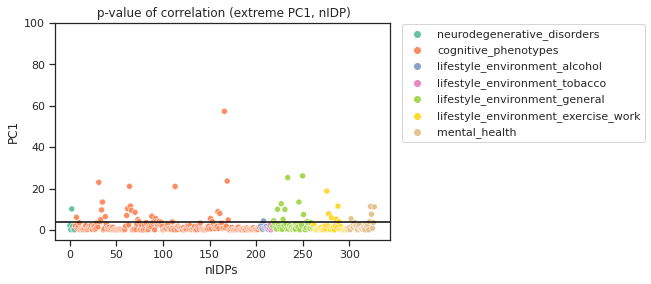

In [26]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC1', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC1, nIDP)')
plt.ylim([-5,100])
plt.show()
plt.close()

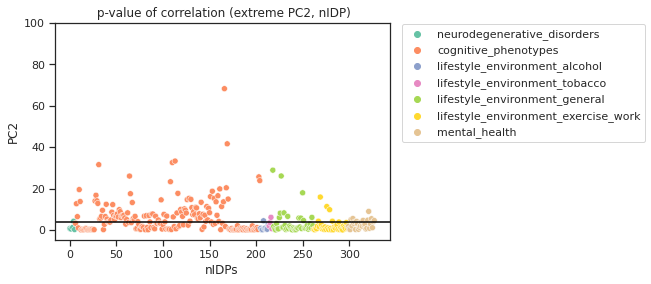

In [27]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC2', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC2, nIDP)')
#plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,100])
plt.show()
plt.close()

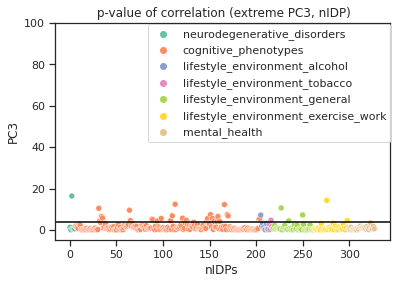

In [28]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC3', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC3, nIDP)')
#plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,100])
plt.show()
plt.close()

In [29]:
print(f'PC1, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,2]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC2, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,3]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC3, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,4]>-np.log10(.05/len(Pvalue_all)))}')

PC1, Number of correlations passing p-value: 52
PC2, Number of correlations passing p-value: 137
PC3, Number of correlations passing p-value: 36
